
# FreeNN

## Goals of this script: 
- I.   Basic definitions
- II.  Monte-Carlo


# I. Basic definitions
Here we consider the $S$-transforms of Marchenko-Pastur distributions, which are of the form:
$$ S_{W_l^T W_l}(m) = \frac{1}{\sigma_l^2} \frac{1}{1+\lambda_l m} \ ,$$
where the $\lambda_i$ are the scale pameters and $\sigma_l^2$ are the variances. 

We have computed in Section 3, Theorem 3.1 of the paper:
$$ S_{J^T J}(m)
 = \frac{m+1}{m M^{\langle -1 \rangle}(m)}
 = \prod_{\ell=1}^L \left[ S_{D_\ell^2}(\Lambda_\ell m) \frac{1}{\sigma_l^2} \frac{1}{1+\Lambda_l m} \right] \ .$$
$$ M_{J^T J}^{\langle -1 \rangle}(m)
 = \frac{m+1}{m}
   \prod_{\ell=1}^L \left[ \frac{\sigma_\ell^2 (1+\Lambda_\ell m)}{S_{D^2_\ell(\Lambda_\ell m)}} \right] \ .$$


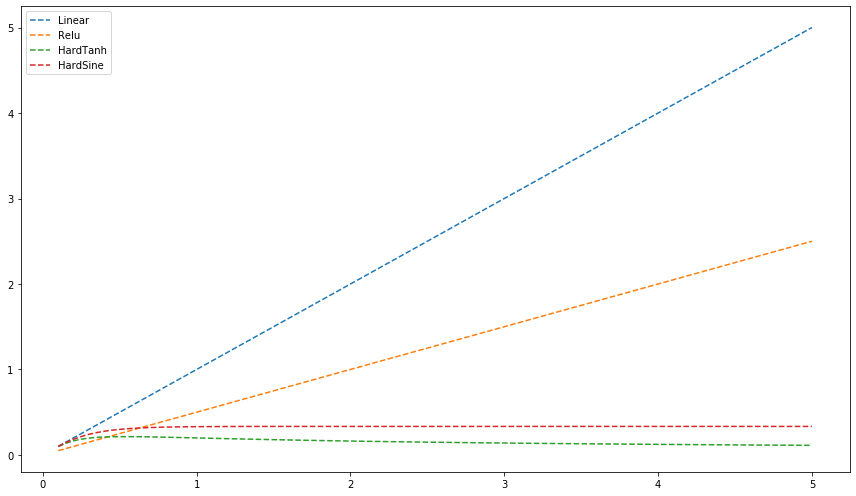

In [3]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt

# Compute q^\ell by recurrence
from scipy import special
def compute_C(q):
    return 0.5*special.erf(1/np.sqrt(2*q))
  
def compute_g( q, non_linearity_string ):
    switcher = {
        'Linear'  : (lambda q: q),
        'Relu'    : (lambda q: 0.5*q),
        'HardTanh': (lambda q: 2*q*compute_C(q) - np.sqrt(2*q/math.pi)*np.exp(-1/(2*q)) ),
        'HardSine': (lambda q: 1/3 + (4/(math.pi**2)*( - np.exp(-0.5*q*math.pi**2) + 0.25*np.exp(-2*q*math.pi**2) ) ) ),
    }
    # Get the function from switcher dictionary
    g = switcher.get(non_linearity_string, lambda: "Invalid non-linearity name")
    # Execute the function
    return g(q)

q_grid = np.linspace(0.1, 5, num=100)
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
for s in ['Linear', 'Relu', 'HardTanh', 'HardSine']:
    ax.plot(q_grid, compute_g(q_grid, s), '--', label=s)
fig.tight_layout()
plt.legend()
plt.show()

In [4]:
# Returns P,Q such that P/Q = 1/(z-1)
def compute_M_basic():
    return ( np.array([1]), np.array([1, -1]) )

def compute_M_Linear(q):
    return compute_basic()
 
def compute_M_Relu(q):
    P, Q = compute_M_basic()
    return ( 0.5*P, Q )

def compute_M_HardTanh(q):
    P, Q = compute_M_basic()
    C    = compute_C(q)
    return ( C*P, Q )

def compute_M_Triangle(q):
    return compute_basic()
  
def compute_M_D( q, non_linearity_string ):
    switcher = {
        'Linear'  : compute_M_Linear,
        'Relu'    : compute_M_Relu,
        'HardTanh': compute_M_HardTanh,
        'HardSine': compute_M_Triangle,
    }
    # Get the function from switcher dictionary
    non_linearity = switcher.get(non_linearity_string, lambda: "Invalid non-linearity name")
    # Execute the function
    return non_linearity(q)

def compute_S_D( q, non_linearity_string ):
    C = compute_C(q)
    switcher = {
        'Linear'  : ( [1], [1] ),
        'Relu'    : ( [1, 1], [1, 0.5] ),
        'HardTanh': ( [1, 1], [1, C] ),
        'HardSine': ( [1], [1] ),
    }
    # Get the function from switcher dictionary
    non_linearity = switcher.get(non_linearity_string, lambda: "Invalid non-linearity name")
    # Execute the function
    return non_linearity

In [5]:
"""
    Input: Polynomial P as numpy array (Larger degree coeff first)
           Scalar s
    Ouput: Polynomial X \mapsto P(sX)
"""
def scale_polynomial( P, s):
    degree    = len(P)-1
    exponents = np.linspace(degree, 0, num=degree+1)
    return P*( s**exponents )

In [9]:
# Array of \lambda_l's
lambdas = [1]*5
Lambdas = np.cumprod(lambdas)
sigma2s = [1]*len(lambdas)
non_linearities = ['Relu']*len(lambdas)
L       = len(lambdas)


# Compute coefficients of M_inverse (numerator and denominator)
# Conventions:
#   - Coefficients are numpy arrays
#   - Highest degree comes first
#

# Compute product of S_D's
num_S, den_S = [1], [1]
q            = 1
for index in range(L):
    non_linearity = non_linearities[index]
    q    = sigma2s[index]*compute_g(q, non_linearity)
    # Compute X \mapsto M_D(X)
    P, Q = compute_S_D(q, non_linearity)
    # Compute X \mapsto M_D( Lambda*X )
    Lambda = Lambdas[index]
    P = scale_polynomial(P, Lambda)
    Q = scale_polynomial(Q, Lambda)
    # Multiply numerators and denominators
    num_S  = np.polymul(num_S, P)
    den_S  = np.polymul(den_S, Q)

# Numerator of M_inverse
roots         = np.append(-1, -1/Lambdas)
leading_coeff = np.prod(Lambdas)*np.prod(sigma2s)
coeff_num     = np.poly( roots ) * leading_coeff
# Of denominator of M_inverse = w
coeff_den     = np.array( [1, 0] )
# Incorporate the inverse product of M_D's
coeff_num  = np.polymul(coeff_num, den_S)
coeff_den  = np.polymul(coeff_den, num_S)

In [10]:
def mean( coeff_num, coeff_den):
    mean = np.polyval(coeff_num, 0) / np.polyval( coeff_den[:-1], 0 )
    return mean

print( mean(coeff_num, coeff_den) )

0.03125


In [11]:
from freenn.core import newton, adaptative

wrapper = newton.Polynomial_Kantorovich_Wrapper( coeff_num, coeff_den)

ModuleNotFoundError: No module named 'freenn'

# II. Computation of the measure (multiple passes)

NameError: name 'adaptative' is not defined

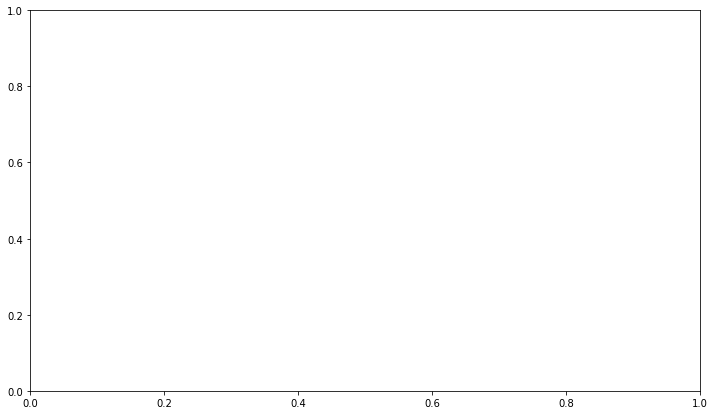

In [12]:
import matplotlib.pyplot as plt
import numpy as np

#N: Space mesh
N=1000
a=-1
b=6

#Init
space_grid = np.linspace(a, b, N)
dx = (b-a)/N

#Multiple passes for the number of iterations
#imaginary_parts = [1.0, 0.1, 0.01, 1e-4, 1e-6]
imaginary_parts = [1e-4]
densities       = []
hilbert_transf  = []
pass_counter    = 0
iter_count      = [ [] for i in space_grid ]
errors1         = [ [] for i in space_grid ]
errors2         = [ [] for i in space_grid ]
choices         = [ [] for i in space_grid ]

j = complex(0,1)
measure_mean = mean(coeff_num, coeff_den)

fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
y_proxy = None
guess   = None
G       = np.array( space_grid + complex(0,1) )
for y in imaginary_parts:
    start = time.time()
    adaptative.reset_counters()
    # Compute
    z = np.array( space_grid + y*complex(0,1) )
    mean_index = np.searchsorted(space_grid, measure_mean)
    if y_proxy is None: #First pass is special
        g                 = adaptative.compute_G_adaptative(measure_mean+j, function_wrapper = wrapper, proxy=None)
        precomputed_proxy = (measure_mean+j,  g)
    # Sweep right
    guess = precomputed_proxy
    for i in range(mean_index, N):
        G[i]  = adaptative.compute_G_adaptative(z[i], function_wrapper = wrapper, proxy=guess)
        guess = ( z[i], G[i] )
    # Sweep left
    guess = precomputed_proxy
    for i in range(mean_index, -1, -1):
        G[i] = adaptative.compute_G_adaptative(z[i], function_wrapper = wrapper, proxy=guess)
        guess = ( z[i], G[i] )
    # Statistics
    pass_counter += 1
    timing        = time.time() - start
    print ('Pass [{}/{}], Duration: {:.1f} ms' 
           .format(pass_counter, len(imaginary_parts), 1000*timing))
    print("Number of calls to subroutine:")
    print("'Newton-Raphson'  :", adaptative.call_counter_NR)
    print("'Attraction basin':", adaptative.call_counter_failed_basin)
    print("")
    # Plot
    ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.5f"%y)
    ax.set(xlabel='Space (x)', ylabel='Value',
           title='Density')
    ax.grid()
    # Update proxy
    y_proxy = y
    precomputed_proxy = ( z[mean_index], G[mean_index])
plt.ylim(0,0.5)
plt.legend()
plt.savefig('multiscale.png')
plt.show()
#
# Final plot
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.5f"%y)
ax.set(xlabel='Space (x)', ylabel='Value',
       title='Density')
ax.grid()
plt.ylim(0,0.5)
plt.legend()
plt.show()

# III. Monte-Carlo

In [18]:
N=2000
num_bins=int(N**(1/2))

# Array of \lambda_l's
lambdas = [1]*2
Lambdas = np.cumprod(lambdas)
sigma2s = [1]*len(lambdas)
non_linearities = ['Relu']*len(lambdas)
L       = len(lambdas)

print("Monte-Carlo sampling for N=%d..."%N)
print(f" |- Number of layers: {L}")
start = time.time()
q     = 1
J     = np.identity(N)
for index in range( len(lambdas) ):
    ratio = lambdas[index]
    non_linearity_string = non_linearities[index]
    dim1, dim2 = J.shape
    q = sigma2s[index]*compute_g(q, non_linearity)
    # Multiply by Gaussian weights
    dim = int(dim1/ratio)
    W = np.random.normal( size=(dim,dim1) )*np.sqrt(sigma2s[index]/dim2)
    J = W.dot( J )
    # Get non linearity derivative
    switcher = {
        'Linear'  : ( lambda q: 1 ),
        'Relu'    : ( lambda q: (q>0)*1.0 ),
        'HardTanh': ( lambda q: (q>-1)*(q<1)*1.0 ),
        'HardSine': ( lambda q: 1 ),
    }
    nl_derivative = switcher.get(non_linearity_string, lambda: "Invalid non-linearity name")
    # Multiply by diagonal
    D = np.random.normal( size=(dim) )
    D = nl_derivative( D )
    D = np.diag( D )
    J = D.dot( J )
# end for
print( " |-Shape of J:", J.shape)
MP = J.transpose().dot( J )
diag, U = np.linalg.eig(MP)
timing        = time.time() - start
print (' |-Duration: {:.1f} ms' 
       .format(1000*timing))

Monte-Carlo sampling for N=2000...
 |- Number of layers: 2
 |-Shape of J: (2000, 2000)
 |-Duration: 2462.7 ms


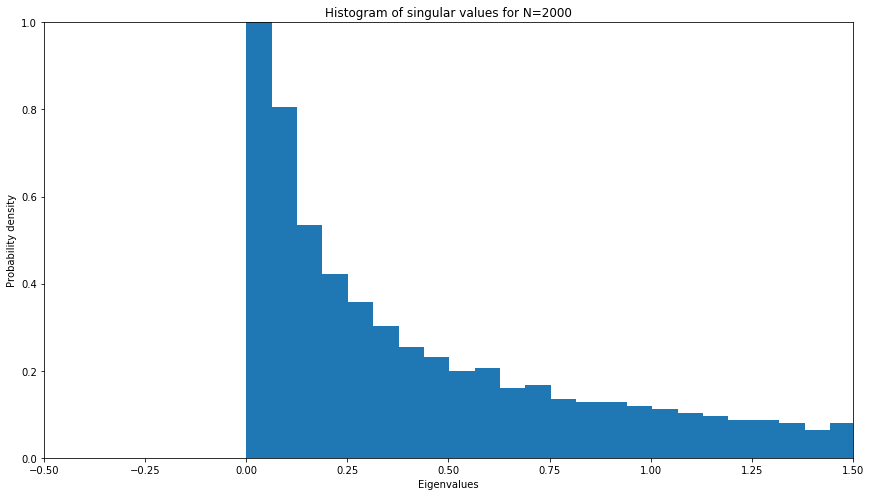

In [19]:
# Histogram of singular values
fig = plt.figure( figsize = (12,7) )
ax = fig.add_subplot( 111 )
n, bins, patches = ax.hist(diag, num_bins, density=True)
ax.plot(space_grid, -np.imag(G)/np.pi, '--', label="y=%.5f"%y)
ax.set_xlabel('Eigenvalues')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of singular values for N={}'.format(N))
fig.tight_layout()
plt.xlim(-0.5, 1.5)
plt.ylim(0, 1)
plt.savefig("mc_vs_lilypads.png")
plt.show()

# IV. Monte-Carlo benchmark

In [23]:
N=2000
num_bins=int(N**(1/2))

timings = []
for l in range(2,42,2):
    # Array of \lambda_l's
    lambdas = [1]*l
    Lambdas = np.cumprod(lambdas)
    sigma2s = [1]*len(lambdas)
    non_linearities = ['Relu']*len(lambdas)
    L       = len(lambdas)

    print("Monte-Carlo sampling for N=%d..."%N)
    print(f" |- Number of layers: {L}")
    start = time.time()
    q     = 1
    J     = np.identity(N)
    for index in range( len(lambdas) ):
        ratio = lambdas[index]
        non_linearity_string = non_linearities[index]
        dim1, dim2 = J.shape
        q = sigma2s[index]*compute_g(q, non_linearity)
        # Multiply by Gaussian weights
        dim = int(dim1/ratio)
        W = np.random.normal( size=(dim,dim1) )*np.sqrt(sigma2s[index]/dim2)
        J = W.dot( J )
        # Get non linearity derivative
        switcher = {
            'Linear'  : ( lambda q: 1 ),
            'Relu'    : ( lambda q: (q>0)*1.0 ),
            'HardTanh': ( lambda q: (q>-1)*(q<1)*1.0 ),
            'HardSine': ( lambda q: 1 ),
        }
        nl_derivative = switcher.get(non_linearity_string, lambda: "Invalid non-linearity name")
        # Multiply by diagonal
        D = np.random.normal( size=(dim) )
        D = nl_derivative( D )
        D = np.diag( D )
        J = D.dot( J )
    # end for
    print( " |-Shape of J:", J.shape)
    MP = J.transpose().dot( J )
    diag, U = np.linalg.eig(MP)
    timing        = time.time() - start
    print (' |-Duration: {:.1f} ms' 
           .format(1000*timing))
    timings.append( timing )

Monte-Carlo sampling for N=2000...
 |- Number of layers: 2
 |-Shape of J: (2000, 2000)
 |-Duration: 2594.8 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 4
 |-Shape of J: (2000, 2000)
 |-Duration: 3002.8 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 6
 |-Shape of J: (2000, 2000)
 |-Duration: 3676.6 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 8
 |-Shape of J: (2000, 2000)
 |-Duration: 5372.0 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 10
 |-Shape of J: (2000, 2000)
 |-Duration: 6380.4 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 12
 |-Shape of J: (2000, 2000)
 |-Duration: 6717.8 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 14
 |-Shape of J: (2000, 2000)
 |-Duration: 7708.2 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 16
 |-Shape of J: (2000, 2000)
 |-Duration: 8850.0 ms
Monte-Carlo sampling for N=2000...
 |- Number of layers: 18
 |-Shape of J: (2000, 2000)
 |-Duration: 9382.4 ms
Monte

In [24]:
timings

[2.5948326587677,
 3.0028457641601562,
 3.6766490936279297,
 5.372035026550293,
 6.3803791999816895,
 6.717818737030029,
 7.70816707611084,
 8.85004997253418,
 9.382407903671265,
 11.228597402572632,
 11.067005395889282,
 20.07433319091797,
 21.80170702934265,
 17.751116037368774,
 21.77049469947815,
 22.30244493484497,
 24.34353470802307,
 23.133735179901123,
 23.825320720672607,
 23.210469245910645]